# File Upload/Download to GitHub from Kaggle Notebooks
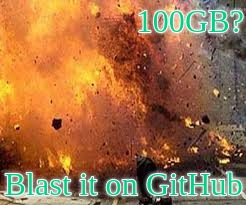
Computer vision challenge such as this, with 100GB sized dataset and a state of the art base model, will hit many developers straight out of the park. Relieing on local bandwidth and computing power will no longer an option. and cloud is the way to go. However cloud charges can be an inhibiting factor to rapidly prototype multiple models on this kind of challenge. 

It will be a blessing to be able to use both kaggle and colab runtimes along with GitHub.
The following solution can be used in current GLD or any other future projects and can certainly add a feather to ones *data engineering* capabilities. This can help in overcoming the limitations of Kaggle/Colab by using GitHub as an intermediate storage. 

> This notebook is an experiment in trying GitHub as one more tool to be considered in data pre/processing activites along with GCP Cloud, and not as a complete alternative.

# Things required to understand this notebook
* Python/Conversions btwn(Numpy, Pandas, strings, tensors)
* GitHub API/Account
* Basic level of Tensorflow usage
* Kaggle/Colab directory structure
* Matplotlib to view images for sanity check
* UNIX/bash commands 

# GitHub Vs GCP
* Data preprocessing activities involves reading the dataset multiple times. This can generate huge data transfer charges from the cloud/GCP. Using GitHub incurs no data transfer and storage chages.
* Training a model involves reading/writing checkpoints, 100's of EPOCHs over dataset, which can again generate considerable cloud storage and data transfer bills.
* However GCP can be an alternative for solutions beyond GitHub's 100GB/repo or 100MB/file limit.
* Competition rules should allow one to upload dataset to public repositories.

# What does this notebook do?
Resize each image to size ~(224,320) preserving the aspect ratio, before uploading to GitHub. After resizing the images, the resultant dataset size is ~15GB, which can easily be accomadated in either kaggle/colab or can be downloaded locally. Either plain images or tar of multiple files can be uploaded

# Motivation: create small dataset
GLD dataset size, 99GB, has been a huge limiting factor in many ways to compete in this image recognition challenge, in a way
* It occupies the whole available user disk space *on kaggle*, which means, no space left out for data manipulation or intermediate data generation related activites.(5GB working directory data limit anyway)
* Not enough Kaggle computing time to validate various ensembling or stacking models
* SSH is not allowed from Kaggle notebook to Colab notebook server(worked briefly and stopped working from next day)
* Can't use *google colab* to train custom models, as the GLD competition dataset size will easily cross the available limits(77GB for CPU/TPU, 37GB for GPU)
* Cannnot edit/remove files in input Dataset. Can only remove entire input dataset, but not individual files, to make space for new edited files.


*Note* Internet switch should be "on" to use this notebook

In [1]:
import os
import shutil
# Dataset parameters:
INPUT_DIR = os.path.join('..', 'input')

DATASET_DIR = os.path.join(INPUT_DIR, 'landmark-recognition-2020')
TEST_IMAGE_DIR = os.path.join(DATASET_DIR, 'test')
TRAIN_IMAGE_DIR = os.path.join(DATASET_DIR, 'train')
TRAIN_LABELMAP_PATH = os.path.join(DATASET_DIR, 'train.csv')
upload_tar_or_plainImages = True #set False to upload plain images

In [2]:
import numpy as np
import PIL
from PIL import Image
import tensorflow as tf

def load_image_tensor(image_path):
  return tf.convert_to_tensor(
      np.array(PIL.Image.open(image_path).convert('RGB')))

def to_hex(image_id) -> str:
  return '{0:0{1}x}'.format(image_id, 16)

def get_image_path(subset, image_id):
  name = to_hex(image_id)
  return os.path.join(DATASET_DIR, subset, name[0], name[1], name[2],'{}.jpg'.format(name))

In [3]:
#for file upload, download, decode
import base64
import io
!pip install PyGithub requests
from github import Github
from pprint import pprint

def get_repo(username="uname",password="pass"):
    # authenticate to github
    g = Github(username, password)
    # get the authenticated user
    user = g.get_user()
    repos = user.get_repos()
    !git config --global user.email "reddy.jayakrishna@gmail.com"
    return(repos[0]) #return the first available repo, change index as per your needs

     |████▊                           | 40 kB 2.7 MB/s eta 0:00:01

     |████████████████████████████████| 274 kB 2.9 MB/s 


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


Below, reads entire image list from the dataset and iterate through each image and upload to Git. To check the upload process with just few(100) images, we have taken head(100) into dataframe from csv, before for loop is added. Edit this line, to upload the entire dataset. 

# Caution
Uploading individual images can be a quite time taking. To make this script run faster, tar and upload one single file, for every ~10,000 image files. set upload_tar_or_plainImages to True to upload tar files.


# Preprocess images into groups, for k-fold training later
Create one tar file for each set of images, having same number of images per class/landmark for ex: if landmark 9 & 10, has 2 images each in traning set. All these 4 images will be part of one tar/group file.
This way, we can train model with all classes having only 2 images once, and in next round train model with all classes having 3 images in training set etc ....This will create 430 groups. However we shall combine few sets having less image count per landmark, to restrict groups to around 50
dict = {imgcnt: list of image paths}

In [4]:
import pandas as pd
import pathlib
from pathlib import Path
from collections import defaultdict
def prepare_imageGroups():
    traincsv = pd.read_csv(DATASET_DIR + '/train.csv')#Remove head to upload whole dataset
    sorteddf = traincsv.groupby('landmark_id').count()
    imgdict = defaultdict(list)
    for landmark,imgcnt in (traincsv.groupby('landmark_id').count()).iterrows():
        landmarks = traincsv.loc[traincsv['landmark_id'] == landmark]
        imgidlist = list(landmarks['id'])
        imgdict[imgcnt['id'].astype(str)].extend(imgidlist)#image count in a class becomes key
    #replace imageid with image path
    for imgcnt, landmark_list in imgdict.items():
        imgdict[imgcnt] = [Path(get_image_path('train',int(landmark,16))) for landmark in landmark_list]
        print("total {} images under all classes having {} images in each class".format(len(imgdict[imgcnt]),imgcnt))
        #some sets have 30k images, divide them into smaller lists
        setsize = len(imgdict[imgcnt])/3000 + 1
        imgdict[imgcnt] = np.array_split(imgdict[imgcnt],setsize)
    return imgdict

# Image resize and save to working/Git directory
If in case of plain images, upload to repository is done below. If uploading tar files, it is done in a create_tarzip function

In [5]:
import random
import subprocess

def upload_imageset_repo(image_paths,repo):
  #image_paths = [x for x in pathlib.Path(TRAIN_IMAGE_DIR).rglob('*.jpg')]
  for index,image_path in enumerate(image_paths):
    #print(index, "original image:",load_image_tensor(image_path).shape, tf.size(load_image_tensor(image_path)), image_path)
    resized_image = tf.image.resize(load_image_tensor(image_path), (224,320), method='bilinear', preserve_aspect_ratio=True)
    #print("resized image:", resized_image.shape, tf.size(resized_image),"\n")

    np_array = resized_image.numpy()#.eval(session=tf.compat.v1.Session())
    imgarray = Image.fromarray(np_array.astype('uint8'),mode='RGB')
    filepath = os.path.normpath(image_path).replace(DATASET_DIR+"/",'')  
    try:
        directory = os.path.dirname(filepath)
        pathlib.Path(directory).mkdir(parents=True, exist_ok=True) 
        imgarray.save(filepath)
    except:
        print("file save failed: ",filepath)

    if(upload_tar_or_plainImages == False): #False to upload plain images
        try:
            with open(filepath, "rb") as imageFile:
                repo.create_file(filepath, "initial commit", imageFile.read())
                imageFile.close()
            subprocess.call(['rm', filepath])
        except:
            print("Git repo file create exception ", filepath)

# Tarzip and upload to Git or GCP
Tar all the files in this set, upload to Git and clear all the local files. Clearing local files is important to not to exceed working directory limits. Files paths need to be relative paths, before sending to tar. This helps while untar into some other VM or floder path.

In [6]:
import tarfile
upload_to_git = True
upload_to_gcp = False
def create_tarzip(directory_to_tar,tarfilename): 
    #os.system("!find "+directory_to_tar+" -name *.jpg | tar -cvzf "+tarfilename+" -T -")

    def make_tarfile(output_filename, source_dir):
        with tarfile.open(output_filename, "w:gz") as tar:
            tar.add(source_dir, arcname=os.path.basename(source_dir))
    make_tarfile(tarfilename,directory_to_tar)
    try:
        if(upload_to_git):
            with open(tarfilename, "rb") as tarFile:
                repo.create_file(tarfilename, "initial commit", tarFile.read())
                tarFile.close()
        if(upload_to_gcp):
            upload_blob(bucket_name, tarfilename, tarfilename)
        #os.system("!rm -rf "+directory_to_tar+"train/")
    except:
        print("Git repo file create exception ", tarfilename)
    subprocess.run(['rm', tarfilename])
    subprocess.call(['rm', '-rf', directory_to_tar+'train'])
    #shutil.rmtree(directory_to_tar+"train")
    
#get all tar files
#untar and mege folders, similar to original dataset
def get_tarzip_from_repo(repo):
    !git clone https://github.com/jkreddy123/gld.git
    basedirpath = "/kaggle/working/gld"
    tar_paths = [x for x in pathlib.Path(basedirpath).rglob('*.tar.gz')]
    for tar_path in tar_paths:
        subprocess.call(['tar', '-xvkf', tar_path]) # use -P if error with /

# Plot images for sanity check
Download few samples images from GitHub and display them using matplotlib for sanity check and correctness. Change samples_to_plot to download/plot desired number of images.

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_images(image_paths,samples_to_plot):
    plt.figure()
    f, axarr = plt.subplots(samples_to_plot,1) 

    #plot few samples, by downloading from GiHub
    #image_paths used from the previous cell
    img_paths = random.sample(image_paths,samples_to_plot)
    for index, img_path in enumerate(img_paths):
        filepath = os.path.normpath(img_path).replace(DATASET_DIR+"/",'')
        git_file = repo.get_contents(filepath)
        file_data_string = git_file.content
        image_data = base64.b64decode(file_data_string)
        image = Image.open(io.BytesIO(image_data))

        axarr[index].imshow(image)
    plt.draw()
    plt.show()
    plt.close()

# Deleting all files from Git
Call below function to delete all the files in the repository. It can be used while testing or to remove complete dataset after project is over. Clone repo to local and prepare list of filenames to delete. CD into repository home directory and edit email, username/XXXX, and gitname/gld(twice) before calling

In [8]:
def delete_files_in_repo(repo):
    !git clone https://github.com/jkreddy123/gld.git
    basedirpath = "/kaggle/working/gld"
    if(upload_tar_or_plainImages == False):
        image_paths = [x for x in pathlib.Path(basedirpath).rglob('*.jpg')]
    else:
        image_paths = [x for x in pathlib.Path(basedirpath).rglob('*.tar.gz')]#*.tar.gz incase of tarballs
    for image_path in image_paths:
      filepath = str(image_path).replace(basedirpath+"/","")#format as per repo path
      print("removing {} from git".format(str(filepath)))
      #os.system("!git rm -f "+filepath)
      try:
        contents = repo.get_contents(filepath)
        repo.delete_file(contents.path, "remove file", contents.sha)
      except:
        print("repo file delete failed: ",filepath)
    #!git commit
    #!git push -f origin master
    shutil.rmtree(basedirpath,ignore_errors=True)

# Upload to GCP storage

In [9]:
import pandas_profiling as pp
# Set your own project id here
PROJECT_ID = 'mlkaggle-288509'
bucket_name = 'gldv2-train-validate-1580470tfrecords' #should be lower case letters

from google.cloud import storage
storage_client = storage.Client(project=PROJECT_ID)

def create_bucket(dataset_name):
    """Creates a new bucket. https://cloud.google.com/storage/docs/ """
    bucket = storage_client.create_bucket(dataset_name)
    print('Bucket {} created'.format(bucket.name))

def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket. https://cloud.google.com/storage/docs/ """
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_name)
    print('File {} uploaded to {}.'.format(
        source_file_name,
        destination_blob_name))
def list_blobs(bucket_name):
    """Lists all the blobs in the bucket. https://cloud.google.com/storage/docs/"""
    blobs = storage_client.list_blobs(bucket_name)
    for blob in blobs:
        print(blob.name)
        
def download_to_kaggle(bucket_name,destination_directory,file_name):
    """Takes the data from your GCS Bucket and puts it into the working directory of your Kaggle notebook"""
    os.makedirs(destination_directory, exist_ok = True)
    blobs = storage_client.list_blobs(bucket_name)
    for blob in blobs:
        full_file_path = os.path.join(destination_directory, blob.name)
        blob.download_to_filename(full_file_path)

# Main code
*Note:* Replace XXXX with your GitHub account details, for the below code to work.

In [10]:
#log the time elapsed, useful when running in background/batch
from timeit import default_timer as timer
from datetime import timedelta
start = timer()
repo = get_repo(username="jkreddy123",password="nethra@411")
imagedict = prepare_imageGroups()
for images_per_landmark, image_paths_arr in imagedict.items():
    for index, image_paths in enumerate(image_paths_arr):
        print("uploading {} images of classes having {} images each".format(len(image_paths),images_per_landmark))
        upload_imageset_repo(image_paths,repo)
        create_tarzip("/kaggle/working/",str(images_per_landmark)+"-"+str(index)+"images"+str(len(image_paths))+".tar.gz")
 
if(False):
    get_tarzip_from_repo(repo)#get all tarfiles and unzip into same folder structure
    plot_images(image_paths,4)#download the uploaded images and plot
    delete_files_in_repo(repo)#clear local and github repo

end = timer()
print('time taken to upload files to GitHub ', timedelta(seconds=end-start))

total 33224 images under all classes having 4 images in each class


total 30744 images under all classes having 8 images in each class


total 25232 images under all classes having 16 images in each class


total 20878 images under all classes having 22 images in each class


total 17250 images under all classes having 25 images in each class


total 12723 images under all classes having 3 images in each class


total 26796 images under all classes having 14 images in each class


total 22446 images under all classes having 18 images in each class


total 30537 images under all classes having 9 images in each class
total 504 images under all classes having 504 images in each class


total 34870 images under all classes having 5 images in each class


total 33426 images under all classes having 6 images in each class


total 20760 images under all classes having 20 images in each class


total 17966 images under all classes having 26 images in each class
total 11176 images under all classes having 44 images in each class


total 27180 images under all classes having 12 images in each class


total 22724 images under all classes having 19 images in each class


total 31913 images under all classes having 7 images in each class


total 30090 images under all classes having 10 images in each class


total 27430 images under all classes having 13 images in each class


total 23052 images under all classes having 17 images in each class


total 14105 images under all classes having 35 images in each class
total 11224 images under all classes having 46 images in each class


total 16767 images under all classes having 27 images in each class
total 10480 images under all classes having 40 images in each class


total 28842 images under all classes having 11 images in each class


total 5494 images under all classes having 82 images in each class
total 8450 images under all classes having 50 images in each class


total 5265 images under all classes having 81 images in each class


total 24735 images under all classes having 15 images in each class
total 9500 images under all classes having 2 images in each class


total 19251 images under all classes having 23 images in each class
total 9256 images under all classes having 52 images in each class


total 3774 images under all classes having 111 images in each class


total 15500 images under all classes having 31 images in each class
total 1668 images under all classes having 139 images in each class
total 5852 images under all classes having 76 images in each class


total 4400 images under all classes having 100 images in each class
total 7920 images under all classes having 60 images in each class


total 10836 images under all classes having 43 images in each class
total 9240 images under all classes having 55 images in each class


total 15260 images under all classes having 28 images in each class
total 8586 images under all classes having 54 images in each class


total 5016 images under all classes having 88 images in each class


total 20580 images under all classes having 21 images in each class


total 18840 images under all classes having 24 images in each class
total 1960 images under all classes having 140 images in each class


total 12060 images under all classes having 36 images in each class


total 15424 images under all classes having 32 images in each class
total 762 images under all classes having 254 images in each class


total 13226 images under all classes having 34 images in each class
total 3848 images under all classes having 104 images in each class
total 6716 images under all classes having 73 images in each class


total 15312 images under all classes having 33 images in each class
total 5355 images under all classes having 85 images in each class


total 6955 images under all classes having 65 images in each class
total 1370 images under all classes having 137 images in each class


total 12177 images under all classes having 41 images in each class
total 7371 images under all classes having 63 images in each class


total 11622 images under all classes having 39 images in each class


total 16140 images under all classes having 30 images in each class
total 9456 images under all classes having 48 images in each class


total 8427 images under all classes having 53 images in each class
total 1158 images under all classes having 193 images in each class
total 8456 images under all classes having 56 images in each class


total 9222 images under all classes having 58 images in each class
total 5984 images under all classes having 68 images in each class
total 4150 images under all classes having 83 images in each class


total 16733 images under all classes having 29 images in each class
total 1296 images under all classes having 162 images in each class
total 1206 images under all classes having 201 images in each class
total 6090 images under all classes having 70 images in each class


total 3861 images under all classes having 117 images in each class
total 3304 images under all classes having 118 images in each class


total 9359 images under all classes having 49 images in each class
total 4183 images under all classes having 89 images in each class


total 3861 images under all classes having 99 images in each class
total 2278 images under all classes having 134 images in each class
total 488 images under all classes having 244 images in each class
total 3948 images under all classes having 84 images in each class


total 6072 images under all classes having 69 images in each class
total 4988 images under all classes having 86 images in each class
total 2850 images under all classes having 114 images in each class


total 9776 images under all classes having 47 images in each class
total 7493 images under all classes having 59 images in each class


total 4730 images under all classes having 110 images in each class
total 4784 images under all classes having 92 images in each class
total 3168 images under all classes having 96 images in each class


total 3298 images under all classes having 97 images in each class
total 7936 images under all classes having 62 images in each class
total 944 images under all classes having 944 images in each class


total 11088 images under all classes having 42 images in each class
total 7392 images under all classes having 66 images in each class
total 2884 images under all classes having 103 images in each class


total 6834 images under all classes having 67 images in each class
total 1770 images under all classes having 177 images in each class
total 2299 images under all classes having 121 images in each class
total 4914 images under all classes having 78 images in each class


total 9078 images under all classes having 51 images in each class
total 7344 images under all classes having 72 images in each class


total 7809 images under all classes having 57 images in each class


total 14541 images under all classes having 37 images in each class
total 8357 images under all classes having 61 images in each class
total 856 images under all classes having 214 images in each class


total 5964 images under all classes having 71 images in each class
total 867 images under all classes having 289 images in each class
total 1266 images under all classes having 211 images in each class


total 12920 images under all classes having 38 images in each class
total 5440 images under all classes having 80 images in each class
total 1521 images under all classes having 169 images in each class


total 4836 images under all classes having 93 images in each class
total 3420 images under all classes having 95 images in each class
total 1572 images under all classes having 131 images in each class
total 2568 images under all classes having 107 images in each class
total 2645 images under all classes having 115 images in each class


total 9270 images under all classes having 45 images in each class
total 4900 images under all classes having 98 images in each class
total 2190 images under all classes having 146 images in each class
total 4002 images under all classes having 87 images in each class


total 4794 images under all classes having 94 images in each class
total 2355 images under all classes having 157 images in each class
total 1185 images under all classes having 237 images in each class
total 1650 images under all classes having 150 images in each class
total 2112 images under all classes having 132 images in each class


total 6656 images under all classes having 64 images in each class
total 2310 images under all classes having 154 images in each class
total 2275 images under all classes having 175 images in each class


total 6391 images under all classes having 77 images in each class
total 1355 images under all classes having 271 images in each class


total 3960 images under all classes having 90 images in each class
total 2295 images under all classes having 135 images in each class
total 4898 images under all classes having 79 images in each class


total 1830 images under all classes having 183 images in each class
total 2074 images under all classes having 122 images in each class
total 1124 images under all classes having 281 images in each class
total 1430 images under all classes having 130 images in each class
total 2054 images under all classes having 158 images in each class


total 624 images under all classes having 312 images in each class
total 1120 images under all classes having 160 images in each class
total 864 images under all classes having 288 images in each class
total 1683 images under all classes having 153 images in each class
total 3277 images under all classes having 113 images in each class


total 2912 images under all classes having 112 images in each class
total 3332 images under all classes having 119 images in each class
total 933 images under all classes having 311 images in each class
total 728 images under all classes having 364 images in each class
total 4662 images under all classes having 74 images in each class


total 4732 images under all classes having 91 images in each class
total 1458 images under all classes having 243 images in each class
total 1368 images under all classes having 171 images in each class
total 4095 images under all classes having 105 images in each class
total 2772 images under all classes having 126 images in each class


total 3737 images under all classes having 101 images in each class
total 4650 images under all classes having 75 images in each class
total 1092 images under all classes having 182 images in each class
total 1860 images under all classes having 155 images in each class
total 1328 images under all classes having 166 images in each class


total 3597 images under all classes having 109 images in each class
total 935 images under all classes having 187 images in each class
total 1595 images under all classes having 145 images in each class
total 2829 images under all classes having 123 images in each class
total 1096 images under all classes having 274 images in each class
total 900 images under all classes having 900 images in each class
total 1540 images under all classes having 308 images in each class


total 2567 images under all classes having 151 images in each class
total 3072 images under all classes having 128 images in each class
total 1086 images under all classes having 181 images in each class
total 2794 images under all classes having 127 images in each class
total 776 images under all classes having 776 images in each class
total 771 images under all classes having 257 images in each class
total 1410 images under all classes having 141 images in each class
total 1600 images under all classes having 200 images in each class
total 585 images under all classes having 195 images in each class


total 1180 images under all classes having 236 images in each class
total 2527 images under all classes having 133 images in each class
total 1232 images under all classes having 176 images in each class
total 702 images under all classes having 351 images in each class
total 2750 images under all classes having 125 images in each class
total 1771 images under all classes having 161 images in each class
total 698 images under all classes having 349 images in each class


total 2322 images under all classes having 129 images in each class
total 1590 images under all classes having 159 images in each class
total 3552 images under all classes having 148 images in each class
total 1404 images under all classes having 156 images in each class
total 1368 images under all classes having 152 images in each class
total 754 images under all classes having 754 images in each class
total 1075 images under all classes having 215 images in each class
total 2916 images under all classes having 108 images in each class


total 3100 images under all classes having 124 images in each class
total 777 images under all classes having 259 images in each class
total 856 images under all classes having 428 images in each class
total 2088 images under all classes having 174 images in each class
total 1295 images under all classes having 185 images in each class
total 247 images under all classes having 247 images in each class
total 3000 images under all classes having 120 images in each class
total 280 images under all classes having 280 images in each class


total 2754 images under all classes having 102 images in each class
total 1134 images under all classes having 189 images in each class
total 736 images under all classes having 368 images in each class
total 1050 images under all classes having 210 images in each class
total 572 images under all classes having 286 images in each class
total 1584 images under all classes having 144 images in each class
total 1602 images under all classes having 178 images in each class
total 2060 images under all classes having 206 images in each class
total 3074 images under all classes having 106 images in each class


total 1730 images under all classes having 173 images in each class
total 1944 images under all classes having 216 images in each class
total 492 images under all classes having 492 images in each class
total 3128 images under all classes having 136 images in each class
total 384 images under all classes having 384 images in each class
total 356 images under all classes having 356 images in each class
total 2664 images under all classes having 888 images in each class
total 1758 images under all classes having 1758 images in each class


total 2208 images under all classes having 138 images in each class
total 436 images under all classes having 218 images in each class
total 2205 images under all classes having 147 images in each class
total 672 images under all classes having 224 images in each class
total 1547 images under all classes having 221 images in each class
total 363 images under all classes having 363 images in each class
total 1504 images under all classes having 188 images in each class
total 1050 images under all classes having 350 images in each class
total 588 images under all classes having 196 images in each class
total 1254 images under all classes having 209 images in each class


total 1611 images under all classes having 179 images in each class
total 1145 images under all classes having 229 images in each class
total 663 images under all classes having 663 images in each class
total 662 images under all classes having 331 images in each class
total 1242 images under all classes having 207 images in each class
total 283 images under all classes having 283 images in each class
total 2900 images under all classes having 116 images in each class
total 1292 images under all classes having 323 images in each class
total 520 images under all classes having 520 images in each class
total 604 images under all classes having 302 images in each class
total 233 images under all classes having 233 images in each class


total 2145 images under all classes having 143 images in each class
total 486 images under all classes having 486 images in each class
total 880 images under all classes having 220 images in each class
total 418 images under all classes having 418 images in each class
total 1490 images under all classes having 149 images in each class
total 463 images under all classes having 463 images in each class
total 1218 images under all classes having 203 images in each class
total 570 images under all classes having 285 images in each class
total 449 images under all classes having 449 images in each class
total 505 images under all classes having 505 images in each class
total 783 images under all classes having 261 images in each class
total 1304 images under all classes having 326 images in each class
total 768 images under all classes having 192 images in each class
total 608 images under all classes having 304 images in each class
total 930 images under all classes having 186 images in ea

total 1260 images under all classes having 180 images in each class
total 325 images under all classes having 325 images in each class
total 927 images under all classes having 309 images in each class
total 1041 images under all classes having 347 images in each class
total 776 images under all classes having 194 images in each class
total 590 images under all classes having 295 images in each class
total 495 images under all classes having 165 images in each class
total 839 images under all classes having 839 images in each class
total 920 images under all classes having 184 images in each class


total 704 images under all classes having 704 images in each class
total 402 images under all classes having 402 images in each class
total 672 images under all classes having 168 images in each class
total 684 images under all classes having 228 images in each class
total 452 images under all classes having 452 images in each class
total 679 images under all classes having 679 images in each class
total 444 images under all classes having 222 images in each class
total 338 images under all classes having 338 images in each class
total 742 images under all classes having 742 images in each class
total 570 images under all classes having 570 images in each class
total 921 images under all classes having 307 images in each class
total 897 images under all classes having 299 images in each class
total 558 images under all classes having 279 images in each class


total 666 images under all classes having 333 images in each class
total 1968 images under all classes having 164 images in each class
total 681 images under all classes having 227 images in each class
total 396 images under all classes having 396 images in each class
total 757 images under all classes having 757 images in each class
total 564 images under all classes having 282 images in each class
total 540 images under all classes having 270 images in each class
total 1048 images under all classes having 262 images in each class


total 1008 images under all classes having 252 images in each class
total 731 images under all classes having 731 images in each class
total 963 images under all classes having 321 images in each class
total 686 images under all classes having 343 images in each class
total 584 images under all classes having 292 images in each class
total 264 images under all classes having 264 images in each class
total 592 images under all classes having 296 images in each class
total 437 images under all classes having 437 images in each class
total 735 images under all classes having 245 images in each class
total 576 images under all classes having 576 images in each class
total 1336 images under all classes having 167 images in each class
total 597 images under all classes having 199 images in each class
total 1020 images under all classes having 170 images in each class


total 1265 images under all classes having 253 images in each class
total 972 images under all classes having 324 images in each class
total 804 images under all classes having 268 images in each class
total 1314 images under all classes having 219 images in each class
total 900 images under all classes having 225 images in each class
total 780 images under all classes having 260 images in each class
total 322 images under all classes having 322 images in each class
total 1200 images under all classes having 300 images in each class
total 202 images under all classes having 202 images in each class
total 1085 images under all classes having 217 images in each class
total 920 images under all classes having 230 images in each class
total 241 images under all classes having 241 images in each class
total 825 images under all classes having 275 images in each class
total 816 images under all classes having 204 images in each class
total 955 images under all classes having 191 images in ea

total 531 images under all classes having 531 images in each class
total 1408 images under all classes having 352 images in each class
total 1565 images under all classes having 313 images in each class
total 298 images under all classes having 298 images in each class
total 720 images under all classes having 240 images in each class
total 390 images under all classes having 390 images in each class
total 848 images under all classes having 212 images in each class
total 462 images under all classes having 231 images in each class
total 238 images under all classes having 238 images in each class
total 409 images under all classes having 409 images in each class
total 425 images under all classes having 425 images in each class
total 990 images under all classes having 198 images in each class
total 477 images under all classes having 477 images in each class
total 668 images under all classes having 334 images in each class
total 978 images under all classes having 163 images in each

total 1562 images under all classes having 142 images in each class
total 527 images under all classes having 527 images in each class
total 473 images under all classes having 473 images in each class
total 1330 images under all classes having 190 images in each class
total 554 images under all classes having 277 images in each class
total 1741 images under all classes having 1741 images in each class
total 502 images under all classes having 502 images in each class
total 263 images under all classes having 263 images in each class
total 464 images under all classes having 232 images in each class
total 381 images under all classes having 381 images in each class
total 891 images under all classes having 297 images in each class
total 358 images under all classes having 358 images in each class
total 628 images under all classes having 314 images in each class
total 632 images under all classes having 316 images in each class
total 258 images under all classes having 258 images in ea

total 484 images under all classes having 242 images in each class
total 255 images under all classes having 255 images in each class
total 669 images under all classes having 223 images in each class
total 832 images under all classes having 208 images in each class
total 854 images under all classes having 427 images in each class
total 602 images under all classes having 301 images in each class
total 538 images under all classes having 538 images in each class
total 801 images under all classes having 267 images in each class
total 732 images under all classes having 366 images in each class
total 423 images under all classes having 423 images in each class


total 1280 images under all classes having 256 images in each class
total 542 images under all classes having 542 images in each class
total 474 images under all classes having 474 images in each class
total 678 images under all classes having 226 images in each class
total 597 images under all classes having 597 images in each class
total 398 images under all classes having 398 images in each class
total 478 images under all classes having 239 images in each class
total 620 images under all classes having 310 images in each class
total 1135 images under all classes having 1135 images in each class
total 336 images under all classes having 336 images in each class
total 945 images under all classes having 315 images in each class
total 410 images under all classes having 205 images in each class
total 503 images under all classes having 503 images in each class


total 798 images under all classes having 266 images in each class
total 482 images under all classes having 482 images in each class
total 470 images under all classes having 235 images in each class
total 337 images under all classes having 337 images in each class
total 1379 images under all classes having 197 images in each class
total 1640 images under all classes having 820 images in each class
total 744 images under all classes having 248 images in each class
total 379 images under all classes having 379 images in each class
total 291 images under all classes having 291 images in each class
total 354 images under all classes having 354 images in each class


total 2231 images under all classes having 2231 images in each class
total 375 images under all classes having 375 images in each class
total 287 images under all classes having 287 images in each class
total 750 images under all classes having 250 images in each class
total 485 images under all classes having 485 images in each class
total 702 images under all classes having 234 images in each class
total 348 images under all classes having 348 images in each class
total 426 images under all classes having 426 images in each class
total 456 images under all classes having 456 images in each class
total 290 images under all classes having 290 images in each class
total 6272 images under all classes having 6272 images in each class


total 330 images under all classes having 330 images in each class
total 966 images under all classes having 966 images in each class
total 306 images under all classes having 306 images in each class
total 508 images under all classes having 508 images in each class
total 339 images under all classes having 339 images in each class
total 479 images under all classes having 479 images in each class
total 246 images under all classes having 246 images in each class
total 971 images under all classes having 971 images in each class
total 293 images under all classes having 293 images in each class
total 514 images under all classes having 514 images in each class
total 502 images under all classes having 251 images in each class
total 861 images under all classes having 861 images in each class
total 335 images under all classes having 335 images in each class
total 662 images under all classes having 662 images in each class
total 303 images under all classes having 303 images in each c

total 656 images under all classes having 656 images in each class
total 920 images under all classes having 920 images in each class
total 393 images under all classes having 393 images in each class
total 1088 images under all classes having 1088 images in each class
total 317 images under all classes having 317 images in each class
total 367 images under all classes having 367 images in each class
total 826 images under all classes having 413 images in each class
total 213 images under all classes having 213 images in each class
total 730 images under all classes having 730 images in each class
total 540 images under all classes having 540 images in each class
total 621 images under all classes having 621 images in each class
total 305 images under all classes having 305 images in each class
total 614 images under all classes having 614 images in each class
total 600 images under all classes having 600 images in each class
total 294 images under all classes having 294 images in each

uploading 2769 images of classes having 4 images each


uploading 2769 images of classes having 4 images each


uploading 2769 images of classes having 4 images each


uploading 2769 images of classes having 4 images each


uploading 2769 images of classes having 4 images each


uploading 2769 images of classes having 4 images each


uploading 2769 images of classes having 4 images each


uploading 2768 images of classes having 4 images each


uploading 2768 images of classes having 4 images each


uploading 2768 images of classes having 4 images each


uploading 2768 images of classes having 4 images each


uploading 2795 images of classes having 8 images each


uploading 2795 images of classes having 8 images each


uploading 2795 images of classes having 8 images each


uploading 2795 images of classes having 8 images each


uploading 2795 images of classes having 8 images each


uploading 2795 images of classes having 8 images each


uploading 2795 images of classes having 8 images each


uploading 2795 images of classes having 8 images each


uploading 2795 images of classes having 8 images each


uploading 2795 images of classes having 8 images each


uploading 2794 images of classes having 8 images each


uploading 2804 images of classes having 16 images each


uploading 2804 images of classes having 16 images each


uploading 2804 images of classes having 16 images each


Git repo file create exception  16-2images2804.tar.gz


uploading 2804 images of classes having 16 images each


Git repo file create exception  16-3images2804.tar.gz


uploading 2804 images of classes having 16 images each


uploading 2803 images of classes having 16 images each


uploading 2803 images of classes having 16 images each


uploading 2803 images of classes having 16 images each


uploading 2803 images of classes having 16 images each


uploading 2983 images of classes having 22 images each


uploading 2983 images of classes having 22 images each


uploading 2983 images of classes having 22 images each


uploading 2983 images of classes having 22 images each


Git repo file create exception  22-3images2983.tar.gz


uploading 2982 images of classes having 22 images each


uploading 2982 images of classes having 22 images each


uploading 2982 images of classes having 22 images each


uploading 2875 images of classes having 25 images each


uploading 2875 images of classes having 25 images each


uploading 2875 images of classes having 25 images each


uploading 2875 images of classes having 25 images each


uploading 2875 images of classes having 25 images each


uploading 2875 images of classes having 25 images each


uploading 2545 images of classes having 3 images each


uploading 2545 images of classes having 3 images each


uploading 2545 images of classes having 3 images each


uploading 2544 images of classes having 3 images each


uploading 2544 images of classes having 3 images each


uploading 2978 images of classes having 14 images each


Git repo file create exception  14-0images2978.tar.gz


uploading 2978 images of classes having 14 images each


Git repo file create exception  14-1images2978.tar.gz


uploading 2978 images of classes having 14 images each


uploading 2977 images of classes having 14 images each


uploading 2977 images of classes having 14 images each


uploading 2977 images of classes having 14 images each


uploading 2977 images of classes having 14 images each


uploading 2977 images of classes having 14 images each


uploading 2977 images of classes having 14 images each


uploading 2806 images of classes having 18 images each


uploading 2806 images of classes having 18 images each


uploading 2806 images of classes having 18 images each


uploading 2806 images of classes having 18 images each


uploading 2806 images of classes having 18 images each


uploading 2806 images of classes having 18 images each


uploading 2805 images of classes having 18 images each


uploading 2805 images of classes having 18 images each


uploading 2777 images of classes having 9 images each


uploading 2776 images of classes having 9 images each


uploading 2776 images of classes having 9 images each


uploading 2776 images of classes having 9 images each


uploading 2776 images of classes having 9 images each


uploading 2776 images of classes having 9 images each


uploading 2776 images of classes having 9 images each


uploading 2776 images of classes having 9 images each


uploading 2776 images of classes having 9 images each


uploading 2776 images of classes having 9 images each


uploading 2776 images of classes having 9 images each


uploading 504 images of classes having 504 images each


uploading 2906 images of classes having 5 images each


uploading 2906 images of classes having 5 images each


uploading 2906 images of classes having 5 images each


uploading 2906 images of classes having 5 images each


uploading 2906 images of classes having 5 images each


uploading 2906 images of classes having 5 images each


uploading 2906 images of classes having 5 images each


uploading 2906 images of classes having 5 images each


uploading 2906 images of classes having 5 images each


uploading 2906 images of classes having 5 images each


uploading 2905 images of classes having 5 images each


uploading 2905 images of classes having 5 images each


uploading 2786 images of classes having 6 images each


uploading 2786 images of classes having 6 images each


uploading 2786 images of classes having 6 images each


uploading 2786 images of classes having 6 images each


uploading 2786 images of classes having 6 images each


uploading 2786 images of classes having 6 images each


uploading 2785 images of classes having 6 images each


uploading 2785 images of classes having 6 images each


uploading 2785 images of classes having 6 images each


uploading 2785 images of classes having 6 images each


uploading 2785 images of classes having 6 images each


uploading 2785 images of classes having 6 images each


uploading 2966 images of classes having 20 images each


uploading 2966 images of classes having 20 images each


uploading 2966 images of classes having 20 images each


uploading 2966 images of classes having 20 images each


uploading 2966 images of classes having 20 images each


uploading 2965 images of classes having 20 images each


uploading 2965 images of classes having 20 images each


uploading 2995 images of classes having 26 images each


uploading 2995 images of classes having 26 images each


uploading 2994 images of classes having 26 images each


uploading 2994 images of classes having 26 images each


uploading 2994 images of classes having 26 images each


uploading 2994 images of classes having 26 images each


uploading 2794 images of classes having 44 images each


uploading 2794 images of classes having 44 images each


uploading 2794 images of classes having 44 images each


uploading 2794 images of classes having 44 images each


uploading 2718 images of classes having 12 images each


uploading 2718 images of classes having 12 images each


uploading 2718 images of classes having 12 images each


uploading 2718 images of classes having 12 images each


uploading 2718 images of classes having 12 images each


uploading 2718 images of classes having 12 images each


uploading 2718 images of classes having 12 images each


uploading 2718 images of classes having 12 images each


uploading 2718 images of classes having 12 images each


uploading 2718 images of classes having 12 images each


uploading 2841 images of classes having 19 images each


uploading 2841 images of classes having 19 images each


uploading 2841 images of classes having 19 images each


uploading 2841 images of classes having 19 images each


uploading 2840 images of classes having 19 images each


uploading 2840 images of classes having 19 images each


uploading 2840 images of classes having 19 images each


uploading 2840 images of classes having 19 images each


uploading 2902 images of classes having 7 images each


uploading 2902 images of classes having 7 images each


uploading 2901 images of classes having 7 images each


Git repo file create exception  7-2images2901.tar.gz


uploading 2901 images of classes having 7 images each


Git repo file create exception  7-3images2901.tar.gz


uploading 2901 images of classes having 7 images each


uploading 2901 images of classes having 7 images each


uploading 2901 images of classes having 7 images each


uploading 2901 images of classes having 7 images each


uploading 2901 images of classes having 7 images each


uploading 2901 images of classes having 7 images each


Git repo file create exception  7-9images2901.tar.gz


uploading 2901 images of classes having 7 images each


uploading 2736 images of classes having 10 images each


uploading 2736 images of classes having 10 images each


uploading 2736 images of classes having 10 images each


uploading 2736 images of classes having 10 images each


uploading 2736 images of classes having 10 images each


uploading 2735 images of classes having 10 images each


uploading 2735 images of classes having 10 images each


uploading 2735 images of classes having 10 images each


uploading 2735 images of classes having 10 images each


uploading 2735 images of classes having 10 images each


uploading 2735 images of classes having 10 images each


uploading 2743 images of classes having 13 images each


uploading 2743 images of classes having 13 images each


uploading 2743 images of classes having 13 images each


uploading 2743 images of classes having 13 images each


uploading 2743 images of classes having 13 images each


uploading 2743 images of classes having 13 images each


uploading 2743 images of classes having 13 images each


uploading 2743 images of classes having 13 images each


uploading 2743 images of classes having 13 images each


uploading 2743 images of classes having 13 images each


Git repo file create exception  13-9images2743.tar.gz


uploading 2882 images of classes having 17 images each


Git repo file create exception  17-0images2882.tar.gz


uploading 2882 images of classes having 17 images each


uploading 2882 images of classes having 17 images each


uploading 2882 images of classes having 17 images each


uploading 2881 images of classes having 17 images each


uploading 2881 images of classes having 17 images each


uploading 2881 images of classes having 17 images each


uploading 2881 images of classes having 17 images each


uploading 2821 images of classes having 35 images each


uploading 2821 images of classes having 35 images each


uploading 2821 images of classes having 35 images each


uploading 2821 images of classes having 35 images each


uploading 2821 images of classes having 35 images each


uploading 2806 images of classes having 46 images each


uploading 2806 images of classes having 46 images each


uploading 2806 images of classes having 46 images each


uploading 2806 images of classes having 46 images each


uploading 2795 images of classes having 27 images each


uploading 2795 images of classes having 27 images each


uploading 2795 images of classes having 27 images each


uploading 2794 images of classes having 27 images each


uploading 2794 images of classes having 27 images each


uploading 2794 images of classes having 27 images each


uploading 2620 images of classes having 40 images each


uploading 2620 images of classes having 40 images each


uploading 2620 images of classes having 40 images each


uploading 2620 images of classes having 40 images each


uploading 2885 images of classes having 11 images each


uploading 2885 images of classes having 11 images each


uploading 2884 images of classes having 11 images each


uploading 2884 images of classes having 11 images each


uploading 2884 images of classes having 11 images each


uploading 2884 images of classes having 11 images each


uploading 2884 images of classes having 11 images each


uploading 2884 images of classes having 11 images each


uploading 2884 images of classes having 11 images each


uploading 2884 images of classes having 11 images each


uploading 2747 images of classes having 82 images each


uploading 2747 images of classes having 82 images each


uploading 2817 images of classes having 50 images each


uploading 2817 images of classes having 50 images each


uploading 2816 images of classes having 50 images each


uploading 2633 images of classes having 81 images each


uploading 2632 images of classes having 81 images each


uploading 2749 images of classes having 15 images each


uploading 2749 images of classes having 15 images each


uploading 2749 images of classes having 15 images each


uploading 2748 images of classes having 15 images each


uploading 2748 images of classes having 15 images each


uploading 2748 images of classes having 15 images each


uploading 2748 images of classes having 15 images each


uploading 2748 images of classes having 15 images each


uploading 2748 images of classes having 15 images each


uploading 2375 images of classes having 2 images each


uploading 2375 images of classes having 2 images each


uploading 2375 images of classes having 2 images each


uploading 2375 images of classes having 2 images each


uploading 2751 images of classes having 23 images each


uploading 2750 images of classes having 23 images each


uploading 2750 images of classes having 23 images each


uploading 2750 images of classes having 23 images each


uploading 2750 images of classes having 23 images each


uploading 2750 images of classes having 23 images each


uploading 2750 images of classes having 23 images each


uploading 2314 images of classes having 52 images each


uploading 2314 images of classes having 52 images each


uploading 2314 images of classes having 52 images each


uploading 2314 images of classes having 52 images each


uploading 1887 images of classes having 111 images each


uploading 1887 images of classes having 111 images each


uploading 2584 images of classes having 31 images each


uploading 2584 images of classes having 31 images each


uploading 2583 images of classes having 31 images each


uploading 2583 images of classes having 31 images each


uploading 2583 images of classes having 31 images each


uploading 2583 images of classes having 31 images each


uploading 1668 images of classes having 139 images each


uploading 2926 images of classes having 76 images each


uploading 2926 images of classes having 76 images each


uploading 2200 images of classes having 100 images each


uploading 2200 images of classes having 100 images each


uploading 2640 images of classes having 60 images each


uploading 2640 images of classes having 60 images each


uploading 2640 images of classes having 60 images each


uploading 2709 images of classes having 43 images each


uploading 2709 images of classes having 43 images each


uploading 2709 images of classes having 43 images each


uploading 2709 images of classes having 43 images each


uploading 2310 images of classes having 55 images each


uploading 2310 images of classes having 55 images each


uploading 2310 images of classes having 55 images each


uploading 2310 images of classes having 55 images each


uploading 2544 images of classes having 28 images each


uploading 2544 images of classes having 28 images each


uploading 2543 images of classes having 28 images each


uploading 2543 images of classes having 28 images each


uploading 2543 images of classes having 28 images each


uploading 2543 images of classes having 28 images each


uploading 2862 images of classes having 54 images each


uploading 2862 images of classes having 54 images each


uploading 2862 images of classes having 54 images each


uploading 2508 images of classes having 88 images each


uploading 2508 images of classes having 88 images each


uploading 2940 images of classes having 21 images each


uploading 2940 images of classes having 21 images each


uploading 2940 images of classes having 21 images each


uploading 2940 images of classes having 21 images each


uploading 2940 images of classes having 21 images each


Git repo file create exception  21-4images2940.tar.gz


uploading 2940 images of classes having 21 images each


uploading 2940 images of classes having 21 images each


uploading 2692 images of classes having 24 images each


uploading 2692 images of classes having 24 images each


uploading 2692 images of classes having 24 images each


uploading 2691 images of classes having 24 images each


uploading 2691 images of classes having 24 images each


uploading 2691 images of classes having 24 images each


uploading 2691 images of classes having 24 images each


uploading 1960 images of classes having 140 images each


uploading 2412 images of classes having 36 images each


uploading 2412 images of classes having 36 images each


uploading 2412 images of classes having 36 images each


uploading 2412 images of classes having 36 images each


uploading 2412 images of classes having 36 images each


uploading 2571 images of classes having 32 images each


uploading 2571 images of classes having 32 images each


uploading 2571 images of classes having 32 images each


uploading 2571 images of classes having 32 images each


uploading 2570 images of classes having 32 images each


uploading 2570 images of classes having 32 images each


uploading 762 images of classes having 254 images each


uploading 2646 images of classes having 34 images each


uploading 2645 images of classes having 34 images each


uploading 2645 images of classes having 34 images each


uploading 2645 images of classes having 34 images each


uploading 2645 images of classes having 34 images each


uploading 1924 images of classes having 104 images each


uploading 1924 images of classes having 104 images each


uploading 2239 images of classes having 73 images each


uploading 2239 images of classes having 73 images each


uploading 2238 images of classes having 73 images each


uploading 2552 images of classes having 33 images each


uploading 2552 images of classes having 33 images each


uploading 2552 images of classes having 33 images each


uploading 2552 images of classes having 33 images each


uploading 2552 images of classes having 33 images each


uploading 2552 images of classes having 33 images each


uploading 2678 images of classes having 85 images each


uploading 2677 images of classes having 85 images each


uploading 2319 images of classes having 65 images each


uploading 2318 images of classes having 65 images each


uploading 2318 images of classes having 65 images each


uploading 1370 images of classes having 137 images each


uploading 2436 images of classes having 41 images each


uploading 2436 images of classes having 41 images each


uploading 2435 images of classes having 41 images each


uploading 2435 images of classes having 41 images each


uploading 2435 images of classes having 41 images each


uploading 2457 images of classes having 63 images each


uploading 2457 images of classes having 63 images each


uploading 2457 images of classes having 63 images each


uploading 2906 images of classes having 39 images each


uploading 2906 images of classes having 39 images each


uploading 2905 images of classes having 39 images each


uploading 2905 images of classes having 39 images each


uploading 2690 images of classes having 30 images each


uploading 2690 images of classes having 30 images each


uploading 2690 images of classes having 30 images each


uploading 2690 images of classes having 30 images each


uploading 2690 images of classes having 30 images each


uploading 2690 images of classes having 30 images each


uploading 2364 images of classes having 48 images each


uploading 2364 images of classes having 48 images each


uploading 2364 images of classes having 48 images each


uploading 2364 images of classes having 48 images each


uploading 2809 images of classes having 53 images each


uploading 2809 images of classes having 53 images each


uploading 2809 images of classes having 53 images each


uploading 1158 images of classes having 193 images each


uploading 2819 images of classes having 56 images each


uploading 2819 images of classes having 56 images each


uploading 2818 images of classes having 56 images each


uploading 2306 images of classes having 58 images each


uploading 2306 images of classes having 58 images each


uploading 2305 images of classes having 58 images each


uploading 2305 images of classes having 58 images each


uploading 2992 images of classes having 68 images each


uploading 2992 images of classes having 68 images each


uploading 2075 images of classes having 83 images each


uploading 2075 images of classes having 83 images each


uploading 2789 images of classes having 29 images each


uploading 2789 images of classes having 29 images each


uploading 2789 images of classes having 29 images each


uploading 2789 images of classes having 29 images each


uploading 2789 images of classes having 29 images each


uploading 2788 images of classes having 29 images each


uploading 1296 images of classes having 162 images each


uploading 1206 images of classes having 201 images each


uploading 2030 images of classes having 70 images each


uploading 2030 images of classes having 70 images each


uploading 2030 images of classes having 70 images each


uploading 1931 images of classes having 117 images each


uploading 1930 images of classes having 117 images each


uploading 1652 images of classes having 118 images each


uploading 1652 images of classes having 118 images each


uploading 2340 images of classes having 49 images each


uploading 2340 images of classes having 49 images each


uploading 2340 images of classes having 49 images each


uploading 2339 images of classes having 49 images each


uploading 2092 images of classes having 89 images each


uploading 2091 images of classes having 89 images each


uploading 1931 images of classes having 99 images each


uploading 1930 images of classes having 99 images each


uploading 2278 images of classes having 134 images each


uploading 488 images of classes having 244 images each


uploading 1974 images of classes having 84 images each


uploading 1974 images of classes having 84 images each


Git repo file create exception  84-1images1974.tar.gz


uploading 2024 images of classes having 69 images each


uploading 2024 images of classes having 69 images each


uploading 2024 images of classes having 69 images each


uploading 2494 images of classes having 86 images each


uploading 2494 images of classes having 86 images each


uploading 2850 images of classes having 114 images each


uploading 2444 images of classes having 47 images each


uploading 2444 images of classes having 47 images each


uploading 2444 images of classes having 47 images each


uploading 2444 images of classes having 47 images each


uploading 2498 images of classes having 59 images each


uploading 2498 images of classes having 59 images each


uploading 2497 images of classes having 59 images each


uploading 2365 images of classes having 110 images each


uploading 2365 images of classes having 110 images each


uploading 2392 images of classes having 92 images each


uploading 2392 images of classes having 92 images each


uploading 1584 images of classes having 96 images each


uploading 1584 images of classes having 96 images each


uploading 1649 images of classes having 97 images each


uploading 1649 images of classes having 97 images each


uploading 2646 images of classes having 62 images each


uploading 2645 images of classes having 62 images each


uploading 2645 images of classes having 62 images each


uploading 944 images of classes having 944 images each


uploading 2772 images of classes having 42 images each


uploading 2772 images of classes having 42 images each


uploading 2772 images of classes having 42 images each


uploading 2772 images of classes having 42 images each


uploading 2464 images of classes having 66 images each


uploading 2464 images of classes having 66 images each


uploading 2464 images of classes having 66 images each


uploading 2884 images of classes having 103 images each


uploading 2278 images of classes having 67 images each


uploading 2278 images of classes having 67 images each


uploading 2278 images of classes having 67 images each


uploading 1770 images of classes having 177 images each


uploading 2299 images of classes having 121 images each


uploading 2457 images of classes having 78 images each


uploading 2457 images of classes having 78 images each


uploading 2270 images of classes having 51 images each


uploading 2270 images of classes having 51 images each


uploading 2269 images of classes having 51 images each


uploading 2269 images of classes having 51 images each


uploading 2448 images of classes having 72 images each


uploading 2448 images of classes having 72 images each


uploading 2448 images of classes having 72 images each


uploading 2603 images of classes having 57 images each


uploading 2603 images of classes having 57 images each


uploading 2603 images of classes having 57 images each


uploading 2909 images of classes having 37 images each


uploading 2908 images of classes having 37 images each


uploading 2908 images of classes having 37 images each


uploading 2908 images of classes having 37 images each


uploading 2908 images of classes having 37 images each


uploading 2786 images of classes having 61 images each


uploading 2786 images of classes having 61 images each


uploading 2785 images of classes having 61 images each


uploading 856 images of classes having 214 images each


uploading 2982 images of classes having 71 images each


uploading 2982 images of classes having 71 images each


uploading 867 images of classes having 289 images each


uploading 1266 images of classes having 211 images each


uploading 2584 images of classes having 38 images each


uploading 2584 images of classes having 38 images each


uploading 2584 images of classes having 38 images each


uploading 2584 images of classes having 38 images each


uploading 2584 images of classes having 38 images each


uploading 2720 images of classes having 80 images each


uploading 2720 images of classes having 80 images each


uploading 1521 images of classes having 169 images each


uploading 2418 images of classes having 93 images each


uploading 2418 images of classes having 93 images each


uploading 1710 images of classes having 95 images each


uploading 1710 images of classes having 95 images each


uploading 1572 images of classes having 131 images each


uploading 2568 images of classes having 107 images each


uploading 2645 images of classes having 115 images each


uploading 2318 images of classes having 45 images each


uploading 2318 images of classes having 45 images each


uploading 2317 images of classes having 45 images each


uploading 2317 images of classes having 45 images each


uploading 2450 images of classes having 98 images each


uploading 2450 images of classes having 98 images each


uploading 2190 images of classes having 146 images each


uploading 2001 images of classes having 87 images each


uploading 2001 images of classes having 87 images each


uploading 2397 images of classes having 94 images each


uploading 2397 images of classes having 94 images each


uploading 2355 images of classes having 157 images each


uploading 1185 images of classes having 237 images each


uploading 1650 images of classes having 150 images each


uploading 2112 images of classes having 132 images each


uploading 2219 images of classes having 64 images each


uploading 2219 images of classes having 64 images each


uploading 2218 images of classes having 64 images each


uploading 2310 images of classes having 154 images each


uploading 2275 images of classes having 175 images each


uploading 2131 images of classes having 77 images each


uploading 2130 images of classes having 77 images each


uploading 2130 images of classes having 77 images each


uploading 1355 images of classes having 271 images each


uploading 1980 images of classes having 90 images each


uploading 1980 images of classes having 90 images each


uploading 2295 images of classes having 135 images each


uploading 2449 images of classes having 79 images each


uploading 2449 images of classes having 79 images each


uploading 1830 images of classes having 183 images each


uploading 2074 images of classes having 122 images each


uploading 1124 images of classes having 281 images each


uploading 1430 images of classes having 130 images each


uploading 2054 images of classes having 158 images each


uploading 624 images of classes having 312 images each


uploading 1120 images of classes having 160 images each


uploading 864 images of classes having 288 images each


uploading 1683 images of classes having 153 images each


uploading 1639 images of classes having 113 images each


uploading 1638 images of classes having 113 images each


uploading 2912 images of classes having 112 images each


uploading 1666 images of classes having 119 images each


uploading 1666 images of classes having 119 images each


uploading 933 images of classes having 311 images each


uploading 728 images of classes having 364 images each


uploading 2331 images of classes having 74 images each


uploading 2331 images of classes having 74 images each


uploading 2366 images of classes having 91 images each


uploading 2366 images of classes having 91 images each


uploading 1458 images of classes having 243 images each


uploading 1368 images of classes having 171 images each


uploading 2048 images of classes having 105 images each


uploading 2047 images of classes having 105 images each


uploading 2772 images of classes having 126 images each


uploading 1869 images of classes having 101 images each


uploading 1868 images of classes having 101 images each


uploading 2325 images of classes having 75 images each


uploading 2325 images of classes having 75 images each


uploading 1092 images of classes having 182 images each


uploading 1860 images of classes having 155 images each


uploading 1328 images of classes having 166 images each


uploading 1799 images of classes having 109 images each


uploading 1798 images of classes having 109 images each


uploading 935 images of classes having 187 images each


uploading 1595 images of classes having 145 images each


uploading 2829 images of classes having 123 images each


uploading 1096 images of classes having 274 images each


uploading 900 images of classes having 900 images each


uploading 1540 images of classes having 308 images each


uploading 2567 images of classes having 151 images each


uploading 1536 images of classes having 128 images each


uploading 1536 images of classes having 128 images each


uploading 1086 images of classes having 181 images each


uploading 2794 images of classes having 127 images each


uploading 776 images of classes having 776 images each


uploading 771 images of classes having 257 images each


uploading 1410 images of classes having 141 images each


uploading 1600 images of classes having 200 images each


uploading 585 images of classes having 195 images each


uploading 1180 images of classes having 236 images each


uploading 2527 images of classes having 133 images each


uploading 1232 images of classes having 176 images each


uploading 702 images of classes having 351 images each


uploading 2750 images of classes having 125 images each


uploading 1771 images of classes having 161 images each


uploading 698 images of classes having 349 images each


uploading 2322 images of classes having 129 images each


uploading 1590 images of classes having 159 images each


uploading 1776 images of classes having 148 images each


uploading 1776 images of classes having 148 images each


uploading 1404 images of classes having 156 images each


uploading 1368 images of classes having 152 images each


uploading 754 images of classes having 754 images each


uploading 1075 images of classes having 215 images each


uploading 2916 images of classes having 108 images each


uploading 1550 images of classes having 124 images each


uploading 1550 images of classes having 124 images each


uploading 777 images of classes having 259 images each


uploading 856 images of classes having 428 images each


uploading 2088 images of classes having 174 images each


uploading 1295 images of classes having 185 images each


uploading 247 images of classes having 247 images each


uploading 1500 images of classes having 120 images each


uploading 1500 images of classes having 120 images each


uploading 280 images of classes having 280 images each


uploading 2754 images of classes having 102 images each


uploading 1134 images of classes having 189 images each


uploading 736 images of classes having 368 images each


uploading 1050 images of classes having 210 images each


uploading 572 images of classes having 286 images each


uploading 1584 images of classes having 144 images each


uploading 1602 images of classes having 178 images each


uploading 2060 images of classes having 206 images each


uploading 1537 images of classes having 106 images each


Pls Upvote, comment if you find this analysis and code useful in your Machine Learning tasks.
Thanks.